# View files

Now that we have the raw images and the raw labels, we can start viewing each file to see whether they look correct (i.e. are not in the wrong orientation) and have been completely annotated. To view these files, we will use nibabel and matplotlib.

In [49]:
import napari
import torchio as tio
import os
from pathlib import Path
import numpy as np
import pandas as pd

img_dir = './dataset/images/'
label_dir = './dataset/labels/'

info = pd.read_csv('raw_image_info.csv')

Let's display what info we have available in our csv file

In [50]:
info

,image_file_path,raw_annotated_file_path,status,swap_xy,flip_y,check,old_swap_xy,old_flip_y,OLD check,has correct spacing,needs_cropping_after_creation,other notes
0,dataset/images/diurnal_tarsata.nii,//home/jake/projects/mctv_resfiles/ants/diurna...,good,False,False,NaN,False,False,good,FALSE,False,data with incorrect spacing have irregular siz...
1,dataset/images/dampieri_20151218.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good,False,False,NaN,False,False,good,FALSE,False,NaN
2,dataset/images/dampieri_20200218_male_left_167...,//home/jake/projects/mctv_resfiles/fiddlercrab...,good,False,False,NaN,False,False,good (possibly hard to see missing ones at edges),FALSE,False,NaN
3,dataset/images/dampieri_male_16.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
4,dataset/images/flammula_20180307.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good,False,False,NaN,False,False,good,FALSE,False,NaN
5,dataset/images/flammula_20190925_male_left.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
6,dataset/images/flammula_20200327_female_left_1...,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
7,dataset/images/neohelice_20190616_1_cropped.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
8,dataset/images/Hyperia_02_head_FEG190604_014C,//home/jake/projects/mctv_resfiles/hyperiids/h...,good but crop,False,False,NaN,False,False,wrong orientation or image,FALSE,False,NaN
9,dataset/images/Hyperia_01_head_FEG190604_014B,//home/jake/projects/mctv_resfiles/hyperiids/h...,good,False,False,NaN,False,False,good,FALSE,False,NaN


I can see that we have the paths to our images (they are either nifti files or dicom directories). These should be easy to calculate with the following:

In [105]:
images = info.image_file_path

# replace dicom files with their converted nifti alternative
for i, image in enumerate(images):
    if os.path.isdir(image):
        images.iloc[i] = image + '.nii'

images[:10]

0                   dataset/images/diurnal_tarsata.nii
1                 dataset/images/dampieri_20151218.nii
2    dataset/images/dampieri_20200218_male_left_167...
3                  dataset/images/dampieri_male_16.nii
4                 dataset/images/flammula_20180307.nii
5       dataset/images/flammula_20190925_male_left.nii
6    dataset/images/flammula_20200327_female_left_1...
7      dataset/images/neohelice_20190616_1_cropped.nii
8    dataset/images/Hyperia_02_head_FEG190604_014C.nii
9    dataset/images/Hyperia_01_head_FEG190604_014B.nii
Name: image_file_path, dtype: object

In [106]:
print(f'Found {len(labels)} labelled images for analysis')

Found 38 labelled images for analysis


These files are huge, so we need to use nibabel proxy slicing to collect only the data we need for the plot.
Let's prepare by making some nice functions that can load all our images, get the slices we need and plot them.

In [165]:
import matplotlib.pyplot as plt
from matplotlib import colors
import nibabel as nib
import nibabel.nicom.dicomwrappers
import math

def show_slices(slices, custom_colourmap=None):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    fig.set_size_inches(28.5, 20.5)

    if custom_colourmap is not None:
        cmap = colors.ListedColormap(custom_colourmap)
    else:
        cmap = 'gray'

    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap=cmap, interpolation='nearest', origin="lower")
        
def load_and_plot(name, return_array=False):
    """ Load x y and z middle slices of volume and plot efficiently, using nibabel proxy slicing """
    proxy_img = nib.load(name)
    img_shape = proxy_img.shape
    vol1 = proxy_img.dataobj[math.floor(img_shape[0]/2), :, :]
    vol2 = proxy_img.dataobj[:, math.floor(img_shape[1]/2), :]
    vol3 = proxy_img.dataobj[:, :, math.floor(img_shape[2]/2)]
    array = [
        vol1,
        vol2,
        vol3
    ]   
    show_slices(array)
    if return_array:
        return array
    
def load_and_plot_pair(name1, name2, index=0, axis=2, return_array=False):
    """
    Load single axis slice of two volumes and plot efficiently, using nibabel proxy slicing.
    Note, z axis (axis 2) will plot the fastest followed by the y axis (axis 1) due to the way proxy slicing works
    
    """
    proxy_img1 = nib.load(name1)
    proxy_img2 = nib.load(name2)
    if axis == 0:
        vol1 = proxy_img1.dataobj[index, ...] 
        vol2 = proxy_img2.dataobj[index, ...]
    if axis == 1:
        vol1 = proxy_img1.dataobj[:, index, :] 
        vol2 = proxy_img2.dataobj[:, index, :]
    if axis == 2:
        vol1 = proxy_img1.dataobj[..., index] 
        vol2 = proxy_img2.dataobj[..., index]
    array = [
        vol1,
        vol2
    ]   
    show_slices(array)
    if return_array:
        return array

def load_and_plot_stack(name, index_interval=100, axis=2, return_array=False, custom_colourmap=None):
    """
    Load single axis slice of two volumes and plot efficiently, using nibabel proxy slicing.
    Note, z axis (axis 2) will plot the fastest followed by the y axis (axis 1) due to the way proxy slicing works
    
    """
    proxy_img = nib.load(name)

    proxy_img_shape = proxy_img.shape

    array = []
    interval = np.arange(0, proxy_img_shape[axis], index_interval)
    for i in interval:
        if axis == 0:
            vol = proxy_img.dataobj[i, ...] 
        if axis == 1:
            vol = proxy_img.dataobj[:, i, :] 
        if axis == 2:
            vol = proxy_img.dataobj[..., i] 
        array.append(vol)

    show_slices(array, custom_colourmap=custom_colourmap)
    if return_array:
        return array

Now let's go through each scan and make sure the data points match up correctly.

Plotting scan: dataset/images/P_crassipes_FEG190801_034_00001_new.nii
Unique values in label slice are: [0]
Red = rhabdoms and White = corneas


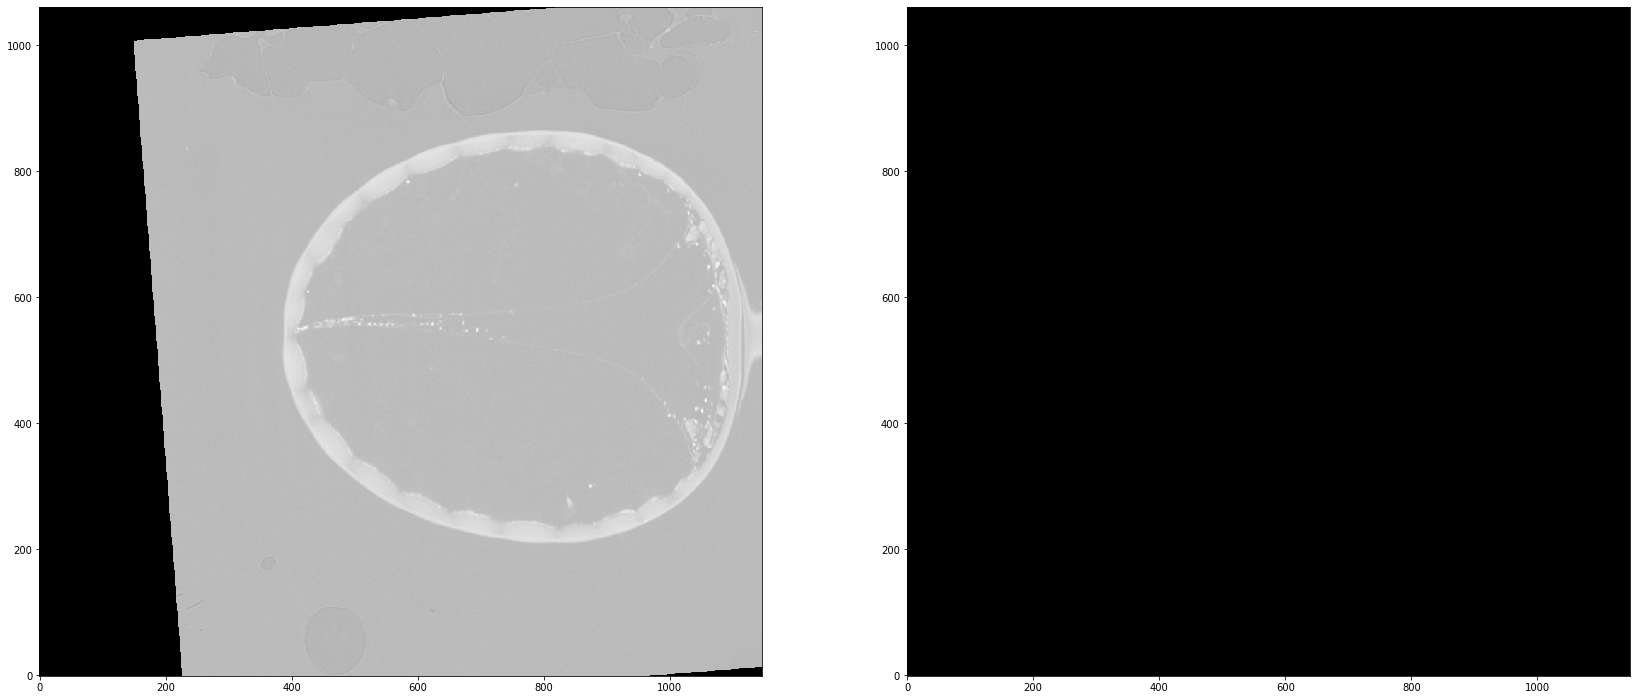

In [166]:
scan = 12
name1 = images[scan]
name2 = labels[scan]

print(f'Plotting scan: {name1}')

array = load_and_plot_pair(name1, name2, index=108, axis=2, return_array = True)

print(f'Unique values in label slice are: {np.unique(array[1])}')
print('Red = rhabdoms and White = corneas')


Plotting scan: dataset/images/P_crassipes_FEG190801_034_00001_new.nii


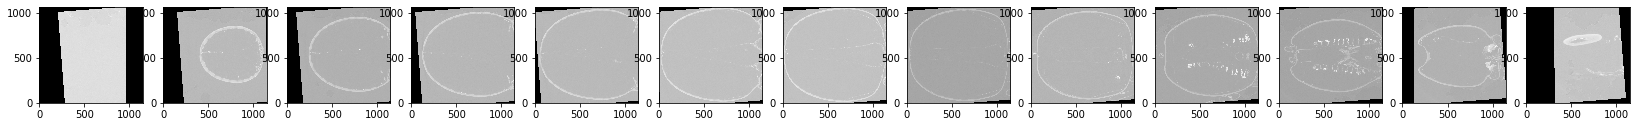

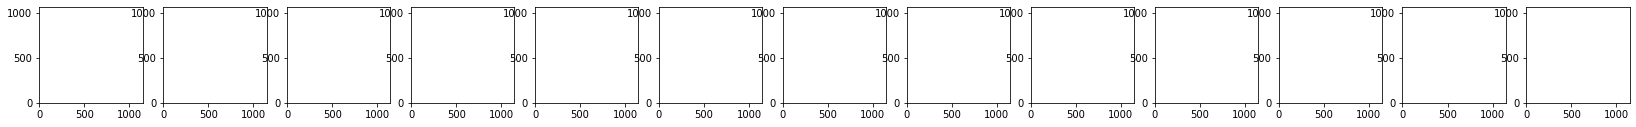

In [175]:
scan = 12
name1 = images[scan]
name2 = labels[scan]

print(f'Plotting scan: {name1}')

array = load_and_plot_stack(name1, index_interval=100, axis=2, return_array = True)
array = load_and_plot_stack(name2, index_interval=100, axis=2, return_array = True, custom_colourmap=['none', 'r', 'g'])